In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import pandas as pd
import sys
# sys.path.append("..")

Chargement du fichier de résultats

In [3]:
experiment_rel_path = "../experiments/RESULTS_3_strata/only_stratum/PROD/2021-05-31_11h40m21s/PCC_inference_all_placettes.csv"
format_percentage_to_float = lambda x: float(x.replace("%",""))
cols_to_format = ['pred_veg_b', 'pred_sol_nu', 'pred_veg_moy', 'pred_veg_h',
                  'vt_veg_b', 'vt_sol_nu', 'vt_veg_moy', 'vt_veg_h','error_veg_b', 
                  'error_veg_moy', 'error_veg_b_and_moy']
df = pd.read_csv(experiment_rel_path, converters={key:format_percentage_to_float for key in cols_to_format})
df[["pl_id","vt_veg_b","vt_veg_moy","vt_veg_h"]].head()

,pl_id,vt_veg_b,vt_veg_moy,vt_veg_h
0,Releve_Lidar_F68,0.0,100.0,0.0
1,2021_POINT_OBS60,25.0,75.0,0.0
2,POINT_OBS67,10.0,75.0,33.0
3,POINT_OBS71,25.0,75.0,90.0
4,Releve_Lidar_F69,10.0,75.0,75.0


Visualization of quantification noise

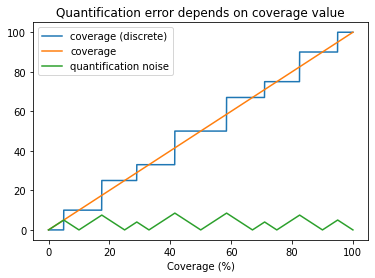

In [18]:
x = np.linspace(0,100,2001)
bins_borders = np.array([5,17.5,29,41.5,58.5,71,82.5,95,101])
bins_centers = np.array([0,10,25,33,50,67,75,90,100])
y_classes = np.digitize(x, bins_borders)
y_quant = bins_centers[y_classes[:,None]].squeeze()
error = np.abs(x-y_quant)

plt.title("Quantification error depends on coverage value")
plt.plot(x, y_quant, label="coverage (discrete)")
plt.plot(x, x, label = "coverage")
plt.plot(x, error, label = "quantification noise")
plt.xlabel("Coverage (%)")
plt.legend()

plt.show()

Calculation of quantification noise expected value, under uniform coverage distribution assumptions

In [19]:
error.mean().round(2)

3.39

Calculation of quantification noise expected value, under plots coverage distribution

In [20]:
errors_by_class = np.zeros(shape=(9,))
for i in range(9):
    errors_by_class[i] = error[y_classes==i].mean()
errors_by_class = errors_by_class.round(2)
errors_by_class_mapper = {val_quant:mean_error for val_quant,mean_error in zip(bins_centers, errors_by_class)}
# See values:
l = list(zip(bins_centers, len(bins_centers)*["->"],errors_by_class, len(bins_centers)*["%pts"]))
l

[(0, '->', 2.48, '%pts'),
 (10, '->', 3.24, '%pts'),
 (25, '->', 3.15, '%pts'),
 (33, '->', 3.52, '%pts'),
 (50, '->', 4.25, '%pts'),
 (67, '->', 3.54, '%pts'),
 (75, '->', 3.13, '%pts'),
 (90, '->', 3.25, '%pts'),
 (100, '->', 2.5, '%pts')]

Actual expected error of oracle by vegetation strata

In [21]:
df_errors = df.copy()
df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]] = df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]].replace(errors_by_class_mapper)
print(f"Actual error due to quantization: {df_errors[['vt_veg_b','vt_veg_moy','vt_veg_h']].values.mean()}")
df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]].describe().loc["mean"]

Actual error due to quantization: 3.070735042735043


vt_veg_b      3.143077
vt_veg_moy    3.047179
vt_veg_h      3.021949
Name: mean, dtype: float64

Calculation of class accuracy

In [45]:
df_class_acc = df.copy()
for coln in ["pred_veg_b", "pred_veg_moy","pred_veg_h"]:
    df_class_acc[coln] = pd.cut(df_class_acc[coln], [-1] + bins_borders.tolist(), labels=bins_centers)

acc_b = (df_class_acc["pred_veg_b"] == df_class_acc["vt_veg_b"]).mean().round(2)
acc_moy = (df_class_acc["pred_veg_moy"] == df_class_acc["vt_veg_moy"]).mean().round(2)
acc_h = (df_class_acc["pred_veg_h"] == df_class_acc["vt_veg_h"]).mean().round(2)
t = [acc_b, acc_moy, acc_h]
print(t, np.mean(t).round(2))

[0.45, 0.45, 0.58] 0.49


Calculation of class accuracy with a margin

In [44]:
df_class_acc = df.copy()

bb = [0] + bins_borders.tolist()
center_to_border_dict = {center: borders for center, borders in zip(bins_centers, zip(bb[:-1], bb[1:]))}

for coln in ["vt_veg_b", "vt_veg_moy","vt_veg_h"]:
    df_class_acc[coln + "_bounds"] = df_class_acc[coln].apply(lambda c: center_to_border_dict[c])

def is_accurate_with_margin(v, bounds, margin = 10):
    if bounds[0] - margin <= v <= bounds[1] + v:
        return True
    else:
        return False

acc2_b = (df_class_acc.apply(lambda x: is_accurate_with_margin(x["pred_veg_b"], x["vt_veg_b"+"_bounds"]), axis=1)).mean().round(2)
acc2_moy = (df_class_acc.apply(lambda x: is_accurate_with_margin(x["pred_veg_moy"], x["vt_veg_moy"+"_bounds"]), axis=1)).mean().round(2)
acc2_h = (df_class_acc.apply(lambda x: is_accurate_with_margin(x["pred_veg_h"], x["vt_veg_h"+"_bounds"]), axis=1)).mean().round(2)
t = [acc2_b, acc2_moy, acc2_h]
print(t, np.mean(t).round(2))

[0.93, 0.72, 0.98] 0.88


Calculation of adapted MAE, relative to class to predict

In [ ]:
# mae2
df_mae2 = df.copy()
bb = [0] + bins_borders.tolist()
center_to_border_dict = {center: borders for center, borders in zip(bins_centers, zip(bb[:-1], bb[1:]))}
center_to_border_dict
def compute_mae2(pred, vt):
    borders = center_to_border_dict[vt]
    if borders[0] <= pred <= borders[1]:
        return 0.0
    else:
        return min( abs(borders[0]-pred), abs(borders[1]-pred))
    
# apply to df
mae2_b = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_b, x.vt_veg_b), axis=1).mean().round(2)
mae2_moy = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_moy, x.vt_veg_moy), axis=1).mean().round(2)
mae2_h = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_h, x.vt_veg_h), axis=1).mean().round(2)
mae2_b, mae2_moy, mae2_h

In [11]:
# get average width of class for each class
def compute_width(vt):
    borders = center_to_border_dict[vt]
    return abs(borders[0] -borders[1])  
# apply to df
width_b = df_mae2.apply(lambda x: compute_width(x.vt_veg_b), axis=1).mean().round(2)
width_moy = df_mae2.apply(lambda x: compute_width(x.vt_veg_moy), axis=1).mean().round(2)
width_h = df_mae2.apply(lambda x: compute_width(x.vt_veg_h), axis=1).mean().round(2)
width_b, width_moy, width_h

(10.75, 9.89, 9.83)

Calculation of induced error under the hypothesis of a normally distributed, small error made by the agent. 

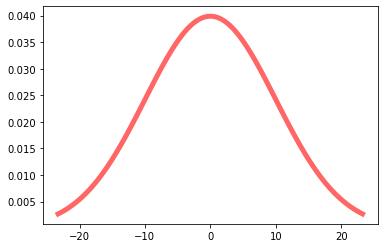

In [76]:
from scipy.stats import norm
fig, ax = plt.subplots(1, 1)
x = np.linspace(imprecision_generator.ppf(0.01),
                imprecision_generator.ppf(0.99), 100)
ax.plot(x, imprecision_generator.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [109]:
from scipy.stats import norm
stdev_of_error = 5  # in percentage of coverage ; 95.4% of values will be in [-2*sigma, +2*sigma]
imprecision_generator = norm(0, stdev_of_error)
print(f"Deltas d for p(e>p) for proba \np = {[0.01,0.05,0.25,0.5,0.75,0.95,0.99]} are\nd = {[np.round(imprecision_generator.ppf(f),1) for f in [0.01,0.05,0.25,0.5,0.75,0.95,0.99]]}")
print(f"proba of an error above 20% is {imprecision_generator.cdf(-20) * 2:.2f}")
# refind
bb = [0] + bins_borders.tolist()
center_to_border_dict = {center: borders for center, borders in zip(bins_centers, zip(bb[:-1], bb[1:]))}

expected_E = []
for center, (lower_b, upper_b) in center_to_border_dict.items():
    E_list = []
    for coverage in np.arange(lower_b,upper_b + 0.1, 0.25):  # we always include both border in this range
        E = 0.0
        W = 0.0
        for imprecision_delta in np.arange(-33,33, 0.25):
            w = imprecision_generator.pdf(imprecision_delta)
            coverage_with_imprecision = coverage + imprecision_delta
            # we accept that 0% and 100% are more likely errors when close to them
            coverage_with_imprecision = max(coverage_with_imprecision, 0)
            coverage_with_imprecision = min(coverage_with_imprecision, 100)
            if lower_b <= coverage_with_imprecision <= upper_b:
                E = E + w * abs(coverage - center)  # quantification noise N°1
            else:
                closest_center = bins_centers[np.argsort(abs(bins_centers - coverage_with_imprecision))[1]]
                E = E + w * abs(coverage -  closest_center)  # quantification noise N°2
            W = W + w
        E_list.append(E / W)
    expected_E_in_class = np.mean(E_list)
    
    print(f"e={expected_E_in_class:.2}% for range [{lower_b};{upper_b}]")
    expected_E.append(expected_E_in_class)
print(f"Expected error with evaluation error of stdev={stdev_of_error} is {np.mean(expected_E).round(2)}")

Deltas d for p(e>p) for proba 
p = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99] are
d = [-11.6, -8.2, -3.4, 0.0, 3.4, 8.2, 11.6]
proba of an error above 20% is 0.00
e=2.9% for range [0;5.0]
e=3.9% for range [5.0;17.5]
e=3.9% for range [17.5;29.0]
e=3.9% for range [29.0;41.5]
e=5.2% for range [41.5;58.5]
e=3.9% for range [58.5;71.0]
e=3.9% for range [71.0;82.5]
e=3.9% for range [82.5;95.0]
e=2.6% for range [95.0;101.0]
Expected error with evaluation error of stdev=5 is 3.8
